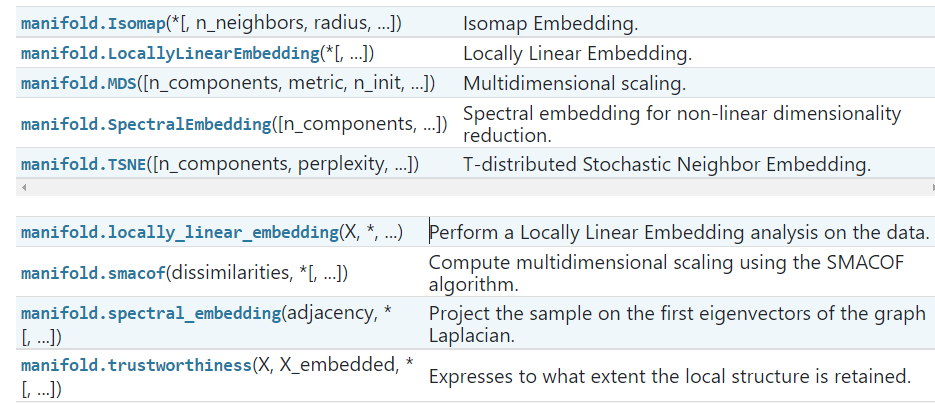

#### 1. 线性降维方式：PCA，LDA、ICA

#### 2. 非线性降维方式：
* 基于核函数的：KPCA、KICA、KDA
* 基于特征值的(流形学习)：ISOMAP、LLE、LE、LPP、LTSA、MVU

### 1.RBT/IBT---PCA

In [5]:
# import Ipynb_importer
from RBT_Enc import*
from cluster import*
from IBT_Enc import*
# from manifold_utils import*

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# from sklearn.metrics import pairwise_distances  # 计算两个2维数组对应元素之间距离,1行表示1个元素
from sklearn import manifold

from sklearn.manifold import trustworthiness

from sklearn import decomposition 
import copy

### 隐私保护降维

In [3]:
## 对数据加密
def D_enc( data ):
    if(data == 'iris'):
        iris = datasets.load_iris()
        X = iris.data
        y = iris.target
    elif(data == 'wine'):
        wine = datasets.load_wine()
        X = wine.data
        y = wine.target
    elif(data=='digits'):
        digits = load_digits()
        # 将数据中全0的列删除
        X = copy.deepcopy(digits.data)
        y = digits.target
        zero  = np.zeros(X.shape[1])
        X = np.insert(X, 0, zero, axis=0) # 将zero插入到D的第1行
        for i in range(X.shape[1]):
            if(sum(X[:,i]!=0)==0):

                X[0][i] = 1   # 若该列全为0 ，则标记为1

        nu_col = np.where(X[0]==1)      #找到所有标记为1的列
        X = np.delete(X, nu_col, axis=1)  # 删除所有标记为1的列
        X = np.delete(X, 0, axis=0)      #删除第一行标记行
        print(X.shape)
    # 数据加密  
    X_ibt = IBT(X)
    return X, X_ibt, y

# 对数据降维
def Dim_reduce(method, X, X_ibt, dim_num):
    if(method=='pca'):
        pca = PCA(n_components=dim_num)      #降为特征2维
        X_reduce = pca.fit(scale(X)).transform(scale(X))
        X_ibt_reduce = pca.fit_transform(X_ibt)
    elif(method=='fastica'):
        fastica = decomposition.FastICA(n_components=dim_num)
        X_reduce = fastica.fit_transform(scale(X))
        X_ibt_reduce = fastica.fit_transform(X_ibt)
    elif(method=='isomap'):
        iso = manifold.Isomap(n_components=dim_num)
        X_reduce = iso.fit_transform(scale(X))
        X_ibt_reduce = iso.fit_transform(X_ibt)
    elif(method=='tsne'):
        tsne = manifold.TSNE(random_state=42)
        X_reduce = tsne.fit_transform(scale(X))
        X_ibt_reduce = tsne.fit_transform(X_ibt)
    elif(method=='mds'):
        mds = manifold.MDS(n_components=dim_num)
        X_reduce = mds.fit_transform(scale(X))
        X_ibt_reduce = mds.fit_transform(X_ibt)
    elif(method=='lle'):
        lle = manifold.LocallyLinearEmbedding(n_components=dim_num)
        X_reduce = lle.fit_transform(scale(X))
        X_ibt_reduce = lle.fit_transform(X_ibt)
    return X_reduce, X_ibt_reduce

# 评价降维效果
def Eva(X, y, X_reduce, X_ibt_reduce):
    # 用可信性评价降维效果
    k = 6     # 近邻数量
    sample_rate = 0.6   #抽样率
    
    trust_D = trustworthiness(X, X_reduce, n_neighbors=k)
    trust_enc_D = trustworthiness(X, X_ibt_reduce, n_neighbors=k)

#     print("不加密降维可信度:",trust_D,'\n'
#            "加密降维可信度:", trust_enc_D) 
#     print("不加密降维连续性:",continuous(k, sample_rate, X, X_r),'\n'
#          "加密降维连续性:", continuous(k, sample_rate, X, X_ibt_pca))

    # 聚类评价
    classes = len(np.unique(y))     
    y1 = KMEANS(X_reduce, classes)
    y2 = KMEANS(X_ibt_reduce, classes)
    km_D =  ARI(y1, y)
    km_enc_D = ARI(y2, y)
#     print("原数据降维后聚类", ARI(y1, y))
#     print("加密数据降维后聚类", ARI(y2, y))

    # 可视化
#     clusters = np.unique(y)
#     # 为每个群集的样本创建散点图
#     for cluster in clusters:
#         # 获取此群集的示例的行索引
#         row_ix = np.where(y == cluster)
#         # 创建这些样本的散布
#         plt.scatter(X[row_ix, 0], X[row_ix, 1])
#     # 绘制散点图
#     plt.show()
    
    temp = np.array([trust_D,trust_enc_D,km_D,km_enc_D])
    return temp


#### 求10次运行结果
* [原始数据降维可信度；加密数据降维可信度；原数据降维聚类效果；加密数据降维聚类效果]

In [8]:
method = 'isomap'
data = 'wine'
val = []

for i in range(10):
    X, X_ibt, y = D_enc( data)
    X_reduce, X_ibt_reduce = Dim_reduce(method, X, X_ibt, 2)
    val.append(Eva(X, y, X_reduce, X_ibt_reduce))
val = np.array(val)

In [9]:
print(np.round(np.mean(val,axis=0),3))
np.round(np.mean( np.abs( val- np.mean(val,axis=0) ),axis=0),3)


[0.723 0.724 0.852 0.84 ]


array([0.   , 0.006, 0.007, 0.011])

In [19]:
# ###可视化

# colors = ["#476A2A", "#785188", "#BD3430","#4A2D4E", "#875525",
#           "#A83683", "#4E655E","#853541", "#3A3120","#535D8E"]
# plt.figure(figsize=(10,10))
# plt.xlim(X_ibt_reduce[:,0].min(), X_ibt_reduce[:,0].max()+1)
# plt.ylim(X_ibt_reduce[:,1].min(), X_ibt_reduce[:,1].max()+1)

# for i in range(len(digits.data)):
#     plt.text(X_ibt_reduce[i,0],X_ibt_reduce[i,1],str(digits.target[i]),
#             color = colors[digits.target[i]],
#             fontdict={'weight':'bold','size': 9})
# plt.xlabel("first pricipal component")
# plt.ylabel("second pricipal component")

### SVM分类任务评价

In [17]:
# 加密前效果
import pylab as pl
import sys
from sklearn.model_selection import train_test_split  # 训练测试数据分割
from sklearn.preprocessing import StandardScaler  # 标准化工具
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report  # 预测结果分析工具
from sklearn.metrics import accuracy_score as acc
# reload(sys)
# sys.setdefaultencoding('utf-8')
# digits = load_digits()
# iris = load_iris()
def class_report(X, y):
    # 分割数据
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=33)

    ss = StandardScaler()
    # fit是实例方法，必须由实例调用
    # X_train = ss.fit_transform(X_train)
    # X_test = ss.transform(X_test)
    # 或
    # X_train = scale(X_train)
    # X_test = scale(X_test)

    lsvc = LinearSVC()
    lsvc.fit(X_train, Y_train)

    Y_predict = lsvc.predict(X_test)
    print(np.round(acc(Y_test, Y_predict),2))
#     print( classification_report(Y_test, Y_predict, target_names=iris.target_names.astype(str)))
    return 0

In [6]:
## 加密数据
X, X_ibt, y = D_enc('iris')

NameError: name 'datasets' is not defined

In [4]:
# 对原始数据和加密数据降维
X_reduce, X_ibt_reduce = Dim_reduce('isomap', X, X_ibt, 10)

NameError: name 'Dim_reduce' is not defined

In [170]:
## 查看分类效果
class_report(X_ibt_reduce, y)

0.95


0

### 决策树分类任务评价

In [180]:
## 加密数据
X, X_ibt, y = D_enc('digits')

(1797, 61)


In [181]:
X_ibt_digits = X_ibt

In [213]:
# 对原始数据和加密数据降维
X_reduce, X_ibt_reduce = Dim_reduce('pca', X, X_ibt, 2) 

In [215]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="gini") #实例化模型
X_train, X_test, Y_train, Y_test = train_test_split(X_reduce, y, test_size=0.25, random_state=33)

clf.fit(X_train, Y_train) # 训练

Y_predict = clf.predict(X_test)
# clf.feature_importances_ # 获取每个属性的贡献程度
# clf.tree_.node_count # 获取节点个数
print(np.round(acc(Y_test, Y_predict),2))

0.47


### 展示加密 降维

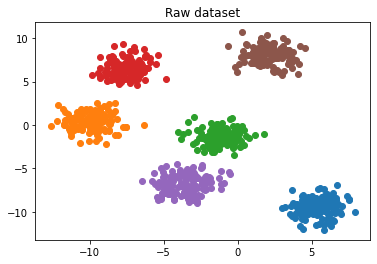

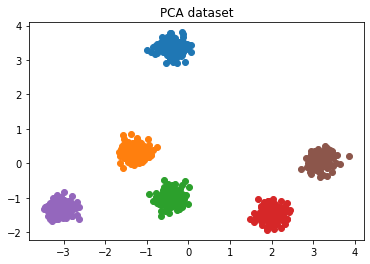

KeyboardInterrupt: 

In [87]:
# ### 展示加密 降维
# from sklearn.datasets import make_blobs
# X,y = make_blobs(n_samples=800, n_features=12,centers=6,random_state=10,)

# clusters = np.unique(y)
# # 为每个群集的样本创建散点图
# for cluster in clusters:
#     # 获取此群集的示例的行索引
#     row_ix = np.where(y == cluster)
#     # 创建这些样本的散布
#     plt.scatter(X[row_ix, 0], X[row_ix, 1])
# # 绘制散点图
# plt.title("Raw dataset")
# plt.show()

# pca = PCA(n_components=2)      #降为特征2维
# X_reduce = pca.fit(scale(X)).transform(scale(X))
# for cluster in clusters:
#     # 获取此群集的示例的行索引
#     row_ix = np.where(y == cluster)
#     # 创建这些样本的散布
#     plt.scatter(X_reduce[row_ix, 0], X_reduce[row_ix, 1])
# # 绘制散点图
# plt.title("PCA dataset")
# plt.show()


# ## 加密
# X_ibt = IBT(X)

# for cluster in clusters:
#     # 获取此群集的示例的行索引
#     row_ix = np.where(y == cluster)
#     # 创建这些样本的散布
#     plt.scatter(X_ibt[row_ix, 0], X_ibt[row_ix, 1])
# # 绘制散点图
# plt.title("IBT dataset")
# plt.show()

# X_ibt_reduce = pca.fit(X_ibt).transform(X_ibt)

# for cluster in clusters:
#     # 获取此群集的示例的行索引
#     row_ix = np.where(y == cluster)
#     # 创建这些样本的散布
#     plt.scatter(X_ibt_reduce[row_ix, 0], X_ibt_reduce[row_ix, 1])
# # 绘制散点图
# plt.title("PCA_IBT dataset")
# plt.show()

In [54]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)      #降为特征2维
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components

# 各组成部分解释的方差百分比
print("explained variance ratio (first two components): %s"
      % str(pca.explained_variance_ratio_) )

explained variance ratio (first two components): [0.92461872 0.05306648]


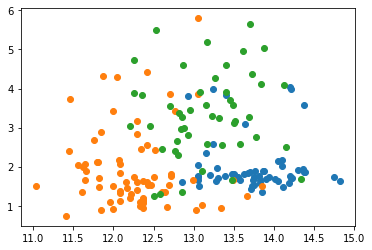

In [73]:
clusters = np.unique(y)
# 为每个群集的样本创建散点图
for cluster in clusters:
    # 获取此群集的示例的行索引
    row_ix = np.where(y == cluster)
    # 创建这些样本的散布
    plt.scatter(X[row_ix, 0], X[row_ix, 1])
# 绘制散点图
plt.show()

In [134]:
# plt.figure()
# colors = ["navy", "turquoise", "darkorange"]
# lw = 2

# for color, i, target_name in zip(colors, [0, 1, 2], target_names):
#     plt.scatter( X_r[y == i, 0], X_r[y == i, 1], color=color, 
#                  alpha=0.8, lw=lw, label=target_name )
    
# plt.legend(loc="best", shadow=False, scatterpoints=1)
# plt.title("PCA of IRIS dataset")
# plt.show()

### 降维可信性与邻近数k的关系：

In [91]:
pca = PCA(n_components=2)      #降为特征2维
iso = manifold.Isomap(n_components=2)
lle = manifold.LocallyLinearEmbedding(n_components=2)

func_list = [pca, iso, lle]
methods = ['PCA', 'ISOMAP', 'LLE']

k_list = [3,5,7,10,12,15,18] 

raw_trust = []
enc_trust = []

wine = datasets.load_wine()
X = wine.data
y = wine.target

* 计算原数据降维效果

In [131]:
### 计算原数据降维效果
i = 0
for func in func_list:
    raw = []   # 存储某降维方法原始数据降维效果
    for kk in k_list:
        X_reduce = func.fit_transform(scale(X))

        raw.append(trustworthiness(X, X_reduce, n_neighbors=kk)) 
    raw = np.array(raw)
    #将所有每种方法的值按行拼起来
    if(i==0):
        raw_trust = np.array([raw])
    else:
        raw_trust = np.insert(raw_trust, i, raw, axis=0)

    i = i+1 

* 计算10次加密数据降维效果

In [95]:
# 做10次实验
enc_trust_10 = []
for i in range(10):
    # 数据加密  
    X_ibt = IBT(X)
    i = 0
    for func in func_list:
        raw = []   # 存储某降维方法原始数据降维效果
        enc = []   # 存储某降维方法加密数据降维效果
        for kk in k_list:

            X_enc_reduce = func.fit_transform(X_ibt)
            ### 将加密前后的降维可信值存入

            enc.append(trustworthiness(X, X_enc_reduce, n_neighbors=kk))

        enc = np.array(enc)

        #将所有每种方法的值按行拼起来
        if(i==0):
            enc_trust = np.array([enc])
        else:
            enc_trust = np.insert(enc_trust, i, enc, axis=0)

        i = i+1
        
    enc_trust_10.append(enc_trust)
    
enc_trust_10 = np.array(enc_trust_10 )

In [99]:
enc_trust = np.mean(enc_trust_10 , axis=0)

(10, 3, 7)

In [112]:
error = np.abs(enc_trust_10 - np.mean(enc_trust_10 , axis=0))
error = np.mean(error,axis=0)

(7,)

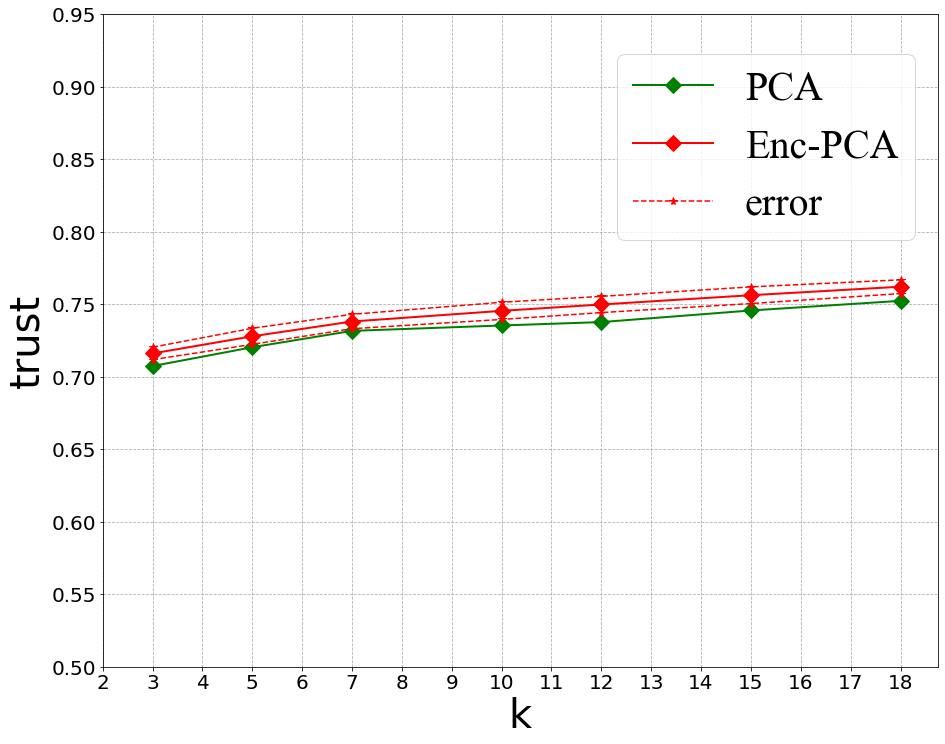

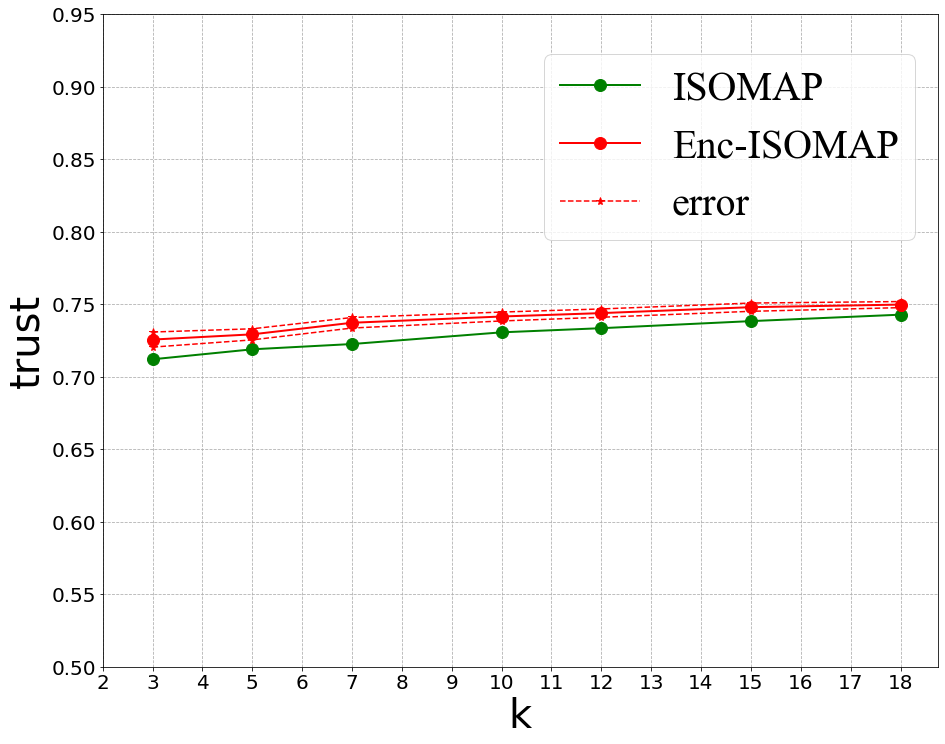

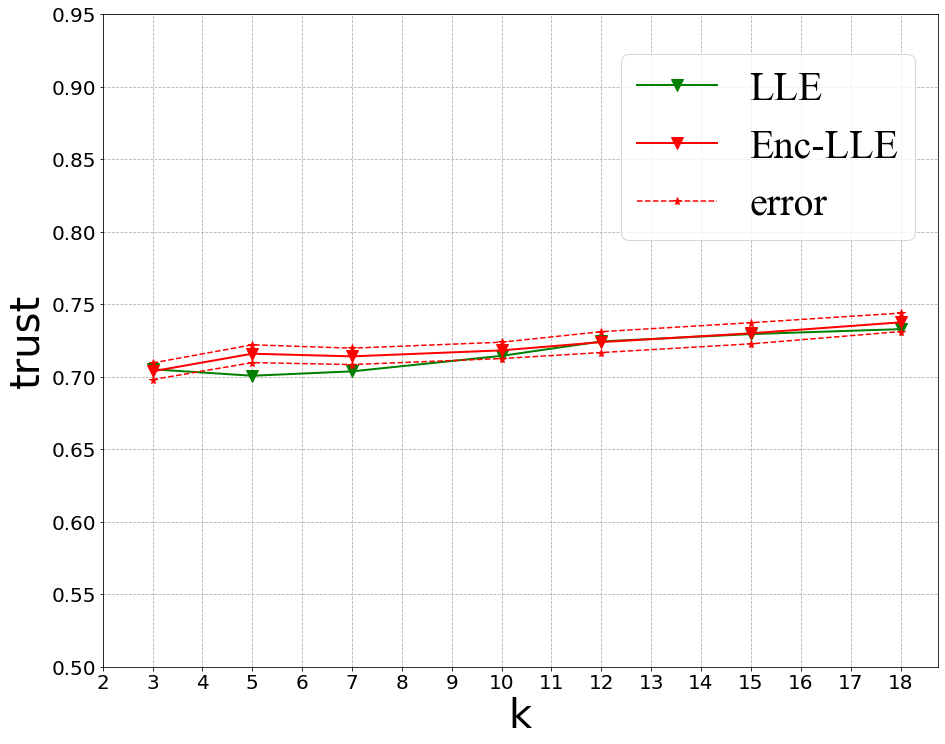

In [134]:
# 可视化   每种方法画一次

for i in range(len(methods)):
    # 画图
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot()
    marker_list = ['D','o','v']
    
    method = methods[i]
    ax.plot( k_list, raw_trust[i] ,label= method, linewidth =2,color='g',marker = marker_list[i],markersize=12)
    ax.plot( k_list, enc_trust[i] ,label= 'Enc-'+method, linewidth =2,color='r',marker = marker_list[i],markersize=12)
    ax.plot( k_list, enc_trust[i]+error[i] ,'--',label= 'error', linewidth =1.5,color='red',marker = '*',markersize=8)
    ax.plot( k_list, enc_trust[i]-error[i] ,'--', linewidth =1.5,color='red',marker = '*',markersize=8)

    plt.xlabel('k',fontsize=40)
    plt.ylabel('trust',fontsize=40) 


    plt.xticks(np.arange(2,19), np.arange(2,19),  size = 20)   
    plt.yticks(np.arange(0.5, 1,0.05) ,  size = 20)

    plt.legend(bbox_to_anchor=(1.02, 1), loc=0, borderaxespad=1
              ,prop={'family':'Times New Roman', 'size' : 40})
    plt.grid(ls= '--')

    fig.subplots_adjust(right=0.85)
    plt.show()

* case1:用聚类效果评价降维效果

In [49]:
# 用旋转加密的数据PCA
X_rbt = RBTD(X)
X_rbt_pca = pca.fit(X_rbt).transform(X_rbt)

X_r = pca.fit(scale(X)).transform(scale(X))

In [75]:

# 用旋转加密的数据PCA
X_ibt = IBT(X)
X_ibt_pca = pca.fit(X_ibt).transform(X_ibt)

[-1.89215, 2.51913, -2.27519, -1.92204, 2.7076, -2.84663, -2.19809]


In [98]:
## 用聚类效果评价
X_r = pca.fit(scale(X)).transform(scale(X))

y1 = KMEANS(X_r, len(clusters))
y2 = KMEANS(X_ibt_pca, len(clusters))

print("原数据降维后聚类效果", ARI(y1, y))
print("旋转加密数据降维后聚类效果", ARI(y2, y))

原数据降维后聚类效果 0.8950582389649661
旋转加密数据降维后聚类效果 0.8803997758776985


* case2:用可信性评价降维效果

In [101]:
k = 6     # 近邻数量
sample_rate = 0.6   #抽样率

print("不加密降维可信度:",trust_measure(k, sample_rate, X, X_r),'\n'
       "加密降维可信度:", trust_measure(k, sample_rate, X, X_ibt_pca))

print("不加密降维连续性:",continuous(k, sample_rate, X, X_r),'\n'
       "加密降维连续性:", continuous(k, sample_rate, X, X_ibt_pca))

不加密降维可信度: 0.7358653501482713 
加密降维可信度: 0.7337308958190765
不加密降维连续性: 0.713755010264933 
加密降维连续性: 0.7111643366898035


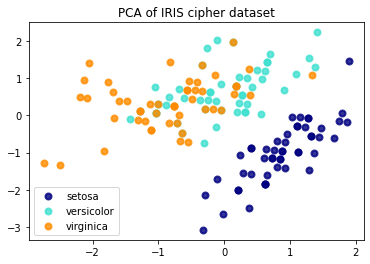

In [88]:
plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter( X_ibt[y == i, 0], X_ibt[y == i, 1], color=color, 
                 alpha=0.8, lw=lw, label=target_name )
    
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS cipher dataset")
plt.show()

In [2]:
X.shape

(1000, 3)

### 2.隐私保护流形学习
* PCA是线性降维，无法检测到非线性特征
* 流形学习是一种 非线性的 降维方法

In [4]:
import warnings
warnings.filterwarnings("ignore")

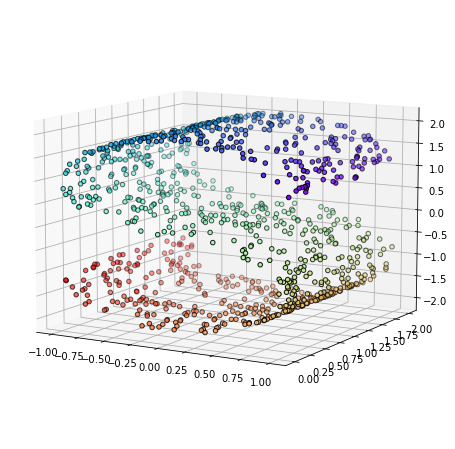

In [9]:
from sklearn.datasets import make_s_curve
from mpl_toolkits.mplot3d import Axes3D

X, y = make_s_curve(n_samples=1000)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot( projection="3d")
# ax = plt.axes(projection = '3d',)

ax.scatter3D(X[:,0], X[:, 1], X[:, 2], c=y,edgecolors='black', cmap=plt.cm.rainbow)
ax.view_init(10,-60)

# fig.savefig('s_curve.eps',format = 'eps',dpi = 600)   # 存在当前路径

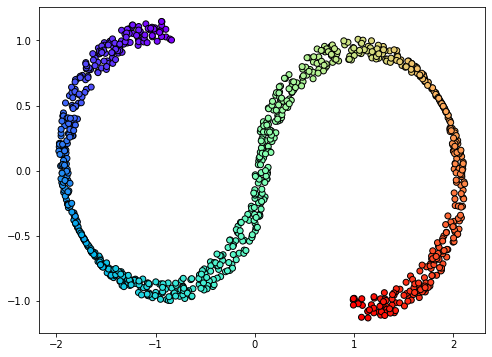

In [7]:
## PCA降维效果

X_pca = PCA(n_components=2).fit_transform(X)
fig = plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:,0], X_pca[:, 1], c=y, edgecolors='black',cmap=plt.cm.rainbow)
plt.show()

fig.savefig('pca_s_curve.eps',format = 'eps',dpi = 600)   # 存在当前路径

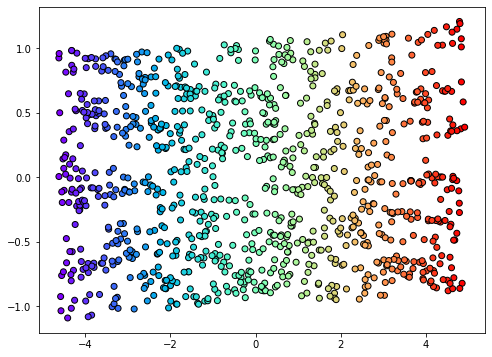

In [8]:
## ISOMAP降维效果
from sklearn.manifold import Isomap

iso = Isomap(n_neighbors=15, n_components=2)
X_iso = iso.fit_transform(X)

fig = plt.figure(figsize=(8, 6))

plt.scatter(X_iso[:,0], X_iso[:, 1], c=y,edgecolors='black',cmap=plt.cm.rainbow)

fig.savefig('iso_s_curve.eps',format = 'eps',dpi = 600)   # 存在当前路径

#### 案例1：使用手写数字集

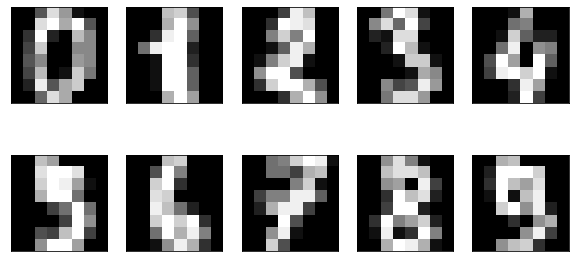

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()

fig, axes = plt.subplots(2, 5, figsize=(10,5),
                        subplot_kw = {'xticks':(), 'yticks':()})

for ax, img in zip(axes.ravel(), digits.images):
    ax.imshow(img, interpolation='none', cmap='gray')

In [54]:
digits.data.shape  #64维

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

### pca降维
* 分类不太精准

Text(0, 0.5, 'second pricipal component')

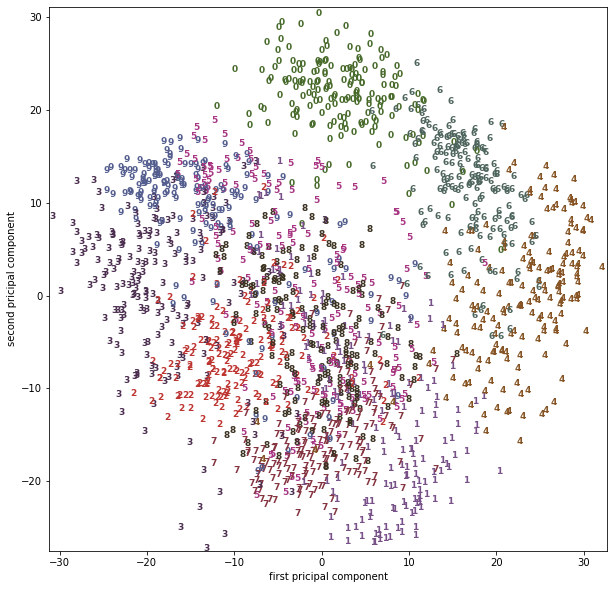

In [4]:
# pca降维
pca = PCA(n_components=2)
pca.fit(digits.data)

digits_pca = pca.transform(digits.data)
colors = ["#476A2A", "#785188", "#BD3430","#4A2D4E", "#875525",
          "#A83683", "#4E655E","#853541", "#3A3120","#535D8E"]
plt.figure(figsize=(10,10))
plt.xlim(digits_pca[:,0].min(), digits_pca[:,0].max()+1)
plt.ylim(digits_pca[:,1].min(), digits_pca[:,1].max()+1)

for i in range(len(digits.data)):
    plt.text(digits_pca[i,0],digits_pca[i,1],str(digits.target[i]),
            color = colors[digits.target[i]],
            fontdict={'weight':'bold','size': 9})
plt.xlabel("first pricipal component")
plt.ylabel("second pricipal component")

In [5]:
digits_pca.data.shape  #2维

(1797, 2)

### mainfold.isomap降维
* 效果更好

C:\Users\Ricemoon\anaconda3\envs\ppdm\lib\site-packages\sklearn\manifold\_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Ricemoon\anaconda3\envs\ppdm\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


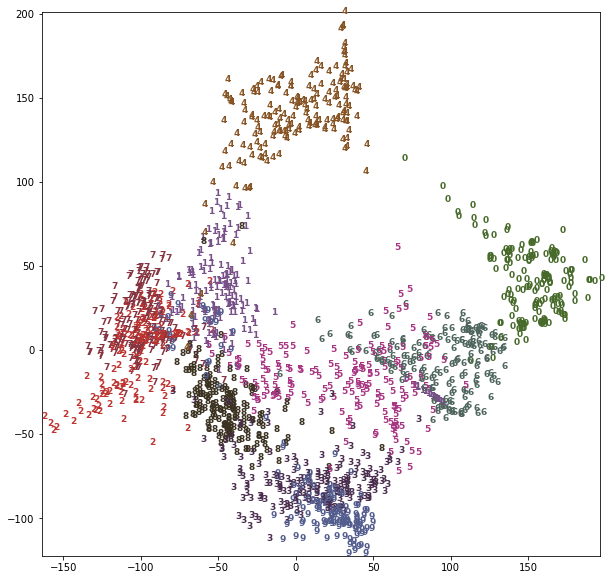

In [22]:

from sklearn.manifold import Isomap
iso = Isomap(n_components=2)
digits_isomap = iso.fit_transform(digits.data)

plt.figure(figsize=(10, 10))
plt.xlim(digits_isomap[:,0].min(), digits_isomap[:,0].max()+1)
plt.ylim(digits_isomap[:,1].min(), digits_isomap[:,1].max()+1)

for i in range(len(digits.data)):
    plt.text(digits_isomap[i,0],digits_isomap[i,1],str(digits.target[i]),
            color = colors[digits.target[i]],
            fontdict={'weight':'bold','size': 9})

### mainfold.TSNE降维
* 效果更好

C:\Users\Ricemoon\anaconda3\envs\ppdm\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Ricemoon\anaconda3\envs\ppdm\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


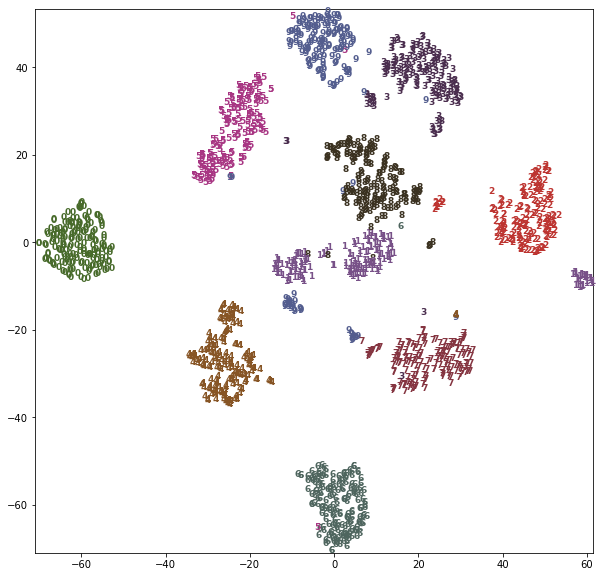

In [27]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
digits_tsne = tsne.fit_transform(digits.data)


plt.figure(figsize=(10, 10))
plt.xlim(digits_tsne[:,0].min(), digits_tsne[:,0].max()+1)
plt.ylim(digits_tsne[:,1].min(), digits_tsne[:,1].max()+1)

for i in range(len(digits.data)):
    plt.text(digits_tsne[i,0],digits_tsne[i,1],str(digits.target[i]),
            color = colors[digits.target[i]],
            fontdict={'weight':'bold','size': 9})

#### 案例2

#### 案例3：ISOMAP on Faces
##### 1.通常使用流形学习来理解高维数据点之间的关系。
* 高维数据常见的是图像：
>例如每组具有1000个像素的一组图像可被认为是1000维度中的点的集合
>每个图像中的每个像素的亮度定义该维度中的坐标
##### 2.这里在人脸数据上应用Isomap
> 使用数据集：Labeled Faces in the Wild

* Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments. Gary B. Huang, Manu Ramesh, Tamara Berg, and Erik Learned-Miller. University of Massachusetts, Amherst, Technical Report 07-49, October, 2007

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=70)
faces.data.shape

(1288, 2914)

In [17]:
"""
>2370张图像，每张图像有2914像素
>即：图像可被认为是2914维空间中的数据点
>可视化其中几个图像
"""

'\n>2370张图像，每张图像有2914像素\n>即：图像可被认为是2914维空间中的数据点\n>可视化其中几个图像\n'

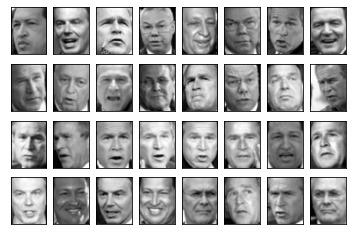

In [7]:
fig, ax = plt.subplots(4,8,subplot_kw = dict(xticks=[],yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

>给高位数据的低维嵌入，以了解图像之间的基本关系，一个有用的开始方法是PCA，并检查解释的方差

In [8]:
from sklearn.manifold import Isomap
model = Isomap(n_components=150)    # 降为2维
proj = model.fit_transform(faces.data)
proj.shape



(1288, 150)

In [24]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier(n_estimators=200)
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=33)
# clf.fit(X_train,Y_train)
# predictions = clf.predict(X_test)

In [25]:
# acc(predictions,Y_test)

0.8222222222222222

In [19]:
"""
>输出是所有输入图像images的二维投影 projection

>from matplotlib import offsetbox
"""

'\n>输出是所有输入图像images的二维投影 projection\n\n>from matplotlib import offsetbox\n'

In [14]:
from matplotlib import offsetbox

def plot_components(data,model,images=None,ax=None,
                   thumb_frac=0.05,cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:,0],proj[:,1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac*max(proj.max(0)-proj.min(0)))**2
        showm_images = np.array([2*proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i]-showm_images)**2, 1)
            if np.min(dist) < min_dist_2:
                #don't show points that are too close
                continue
            showm_images = np.vstack([showm_images,proj[i]])
            imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], cmap=cmap),
                                  proj[i])
            ax.add_artist(imagebox)

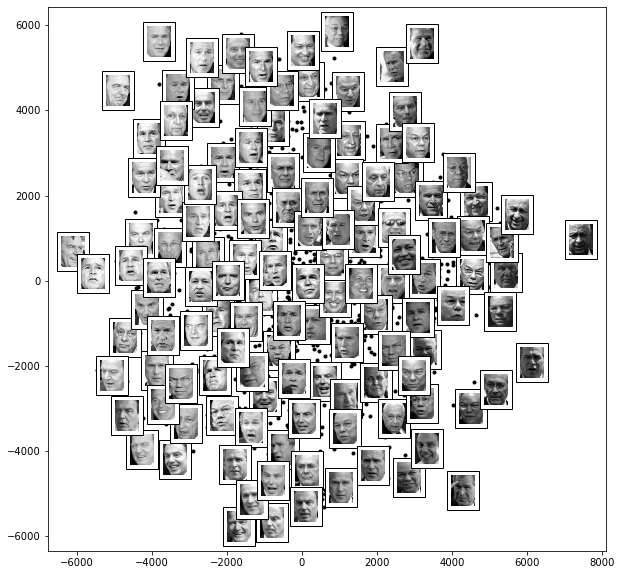

In [15]:
fig,ax = plt.subplots(figsize=(10,10))
plot_components(faces.data, model = Isomap(n_components=2),
               images = faces.images[:,::2,::2])

In [73]:
fa

(2370, 2)

In [13]:
plt.scatter(faces_pca[:,0],proj[:,1],c = faces.target)

NameError: name 'faces_pca' is not defined

In [56]:
## 绘制150个特征空间

#原本有2900维，我们现在来降到150维
# pca = PCA(n_components=150).fit(faces.data)
# V = pca.components_

# fig, axes = plt.subplots(10, 15, figsize=(20, 8), subplot_kw={"xticks": [], "yticks": []})
# for i, ax in enumerate(axes.flat):
#     ax.imshow(V[i, :].reshape(62, 47), cmap="gray")

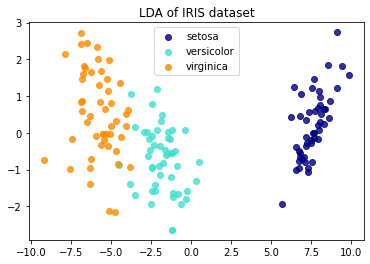

In [11]:
# LDA 是监督
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name)
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of IRIS dataset")

plt.show()